# 04 - Hyperparameter Optimization
## Credit Scoring Model Project

**Learning Objectives:**
- Understand what hyperparameters are and why they matter
- Implement systematic hyperparameter search (Grid Search, Random Search)
- Use cross-validation properly (StratifiedKFold)
- Track optimization experiments with MLflow
- Select the best model configuration
- Avoid overfitting during optimization

**What are Hyperparameters?**
Hyperparameters are settings you choose BEFORE training:
- `max_depth` in decision trees
- `learning_rate` in gradient boosting
- `C` in logistic regression

They're different from model parameters (learned during training like weights).

**Why Optimize?**
Default hyperparameters are rarely optimal for your specific dataset. Systematic tuning can significantly improve performance!

Let's optimize! 🎯

## 📦 Import Libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import time

# ML models and tuning
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV,
    StratifiedKFold, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, make_scorer

# MLflow
import mlflow
import mlflow.sklearn

# Our utilities
import sys
sys.path.append('../')
from src.evaluation import (
    evaluate_model,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_confusion_matrix
)

# Configuration
warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("[OK] Libraries imported successfully!")

[OK] Libraries imported successfully!


## 📂 Load Processed Data

In [2]:
# Load data
data_dir = Path('../data/processed')

X_train = pd.read_csv(data_dir / 'X_train.csv')
X_val = pd.read_csv(data_dir / 'X_val.csv')
y_train = pd.read_csv(data_dir / 'y_train.csv').squeeze()
y_val = pd.read_csv(data_dir / 'y_val.csv').squeeze()

# Combine train and val for cross-validation
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

print(f"[OK] Data loaded!")
print(f"Full dataset for CV: {X_full.shape}")
print(f"Target distribution: {y_full.value_counts(normalize=True).to_dict()}")

[OK] Data loaded!
Full dataset for CV: (307511, 82)
Target distribution: {0: 0.9192711805431351, 1: 0.08072881945686496}


## 🔬 Setup MLflow Experiment

In [3]:
# Set experiment
experiment_name = "credit_scoring_hyperparameter_optimization"
mlflow.set_tracking_uri("sqlite:///../mlruns/mlflow.db")
mlflow.set_experiment(experiment_name)

print(f"[OK] MLflow experiment: {experiment_name}")
print("To view: mlflow ui → http://localhost:5000")

[OK] MLflow experiment: credit_scoring_hyperparameter_optimization
To view: mlflow ui → http://localhost:5000


## 🎯 Hyperparameter Search Strategies

**Three Main Approaches:**

### 1. Grid Search
- **What:** Try ALL combinations of hyperparameters
- **Pros:** Exhaustive, guaranteed to find best in grid
- **Cons:** Slow, exponentially grows with parameters
- **When:** Small search space, plenty of time

### 2. Random Search
- **What:** Try RANDOM combinations
- **Pros:** Faster, often finds good solutions
- **Cons:** May miss optimal combination
- **When:** Large search space, limited time

### 3. Bayesian Optimization (Advanced)
- **What:** Smart search using previous results
- **Pros:** Most efficient, learns from trials
- **Cons:** More complex to set up
- **When:** Expensive models, complex spaces

**We'll use Grid Search for demonstration, but Random Search for large spaces!**

**Cross-Validation:**
We'll use StratifiedKFold with 5 folds to ensure:
- Robust performance estimates
- Class balance in each fold
- Avoid overfitting to validation set

## 📐 Define Hyperparameter Search Spaces

Based on baseline results, we'll optimize the best performing model.

**XGBoost Hyperparameters to Tune:**
- `n_estimators`: Number of boosting rounds (trees)
- `max_depth`: Maximum tree depth
- `learning_rate`: Step size shrinkage
- `subsample`: Fraction of samples per tree
- `colsample_bytree`: Fraction of features per tree
- `min_child_weight`: Minimum sum of instance weight in child
- `gamma`: Minimum loss reduction for split

In [4]:
# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_full == 0).sum() / (y_full == 1).sum()
print(f"Scale pos weight (for class imbalance): {scale_pos_weight:.2f}")

# Define hyperparameter search space for LightGBM
lgbm_param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 50, 70, 100],
    'max_depth': [-1, 5, 10, 15],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'class_weight': ['balanced', None]
}

print(f"\n[DECISION] Using Random Search for LightGBM")
print(f"This will evaluate random combinations from the grid above")

Scale pos weight (for class imbalance): 11.39

[INFO] Grid Search Space:
Total combinations: 3,888
With 5-fold CV: 19,440 total fits

[WARNING] This could take hours! Using Random Search instead...

[DECISION] Using Random Search with 20 iterations (reduced for memory)
This will evaluate 20 random combinations × 5 folds = 100 fits


## 🔀 Setup Stratified Cross-Validation

**Why Stratified?**
- Preserves class distribution in each fold
- Critical for imbalanced datasets
- Ensures each fold is representative

**Why 5 Folds?**
- Good balance between variance and bias
- Not too computationally expensive
- Standard in ML practice

In [5]:
# Setup cross-validation
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

# Verify stratification
print("Verifying stratified splits:")
for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_full, y_full)):
    y_train_fold = y_full.iloc[train_idx]
    y_val_fold = y_full.iloc[val_idx]

    print(f"  Fold {fold_idx + 1}:")
    print(f"    Train: {y_train_fold.value_counts(normalize=True)[1]:.4f} positive")
    print(f"    Val:   {y_val_fold.value_counts(normalize=True)[1]:.4f} positive")

print("\n[OK] All folds maintain class distribution!")

Verifying stratified splits:


  Fold 1:
    Train: 0.0807 positive
    Val:   0.0807 positive
  Fold 2:
    Train: 0.0807 positive
    Val:   0.0807 positive
  Fold 3:
    Train: 0.0807 positive
    Val:   0.0807 positive
  Fold 4:
    Train: 0.0807 positive
    Val:   0.0807 positive


  Fold 5:
    Train: 0.0807 positive
    Val:   0.0807 positive

[OK] All folds maintain class distribution!


## 🔍 Perform Random Search

This will take some time (potentially 30-60 minutes depending on your hardware).

**What's happening:**
1. Random Search samples 50 random combinations from the search space
2. For each combination:
   - Train on 5 different train/val splits (cross-validation)
   - Evaluate on each validation fold
   - Average the scores
3. Select the best performing combination
4. Log everything to MLflow

In [6]:
# Setup LightGBM base model
lgbm_base = LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=RANDOM_STATE,
    n_jobs=1,  # Reduce to avoid memory issues
    verbose=-1
)

# Setup Random Search
print("Starting Random Search...")
print("="*80)

random_search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=lgbm_param_distributions,
    n_iter=20,  # Reduced to save time
    cv=cv,
    scoring='roc_auc',  # Optimize for ROC-AUC
    n_jobs=2,  # Limit parallelism
    verbose=2,  # Show progress
    random_state=RANDOM_STATE,
    return_train_score=True
)

# Fit (this takes time!)
start_time = time.time()
random_search.fit(X_full, y_full)
total_time = time.time() - start_time

print("="*80)
print(f"[OK] Random Search completed in {total_time/60:.2f} minutes")
print(f"\nBest ROC-AUC: {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

Starting Random Search...


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[OK] Random Search completed in 42.18 minutes

Best ROC-AUC: 0.7580

Best Parameters:
  subsample: 0.9
  scale_pos_weight: 11.387150050352467
  n_estimators: 250
  min_child_weight: 7
  max_depth: 5
  learning_rate: 0.05
  gamma: 0.2
  colsample_bytree: 0.9


## 📊 Log Results to MLflow

Log the best model and all trial results to MLflow.

In [7]:
# Log best model to MLflow
with mlflow.start_run(run_name="LightGBM_Optimized_Best"):
    # Log best parameters
    mlflow.log_params(random_search.best_params_)

    # Log best CV score
    mlflow.log_metric("cv_roc_auc_mean", random_search.best_score_)
    mlflow.log_metric("cv_roc_auc_std", random_search.cv_results_['std_test_score'][random_search.best_index_])

    # Evaluate on validation set
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_val)
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]

    # Get detailed metrics
    metrics = evaluate_model(y_val, y_pred, y_pred_proba, "LightGBM_Optimized")

    # Log all metrics
    for metric_name, value in metrics.items():
        if isinstance(value, (int, float)):
            mlflow.log_metric(metric_name, value)

    # Create and log visualizations
    Path('plots').mkdir(exist_ok=True)

    # ROC Curve
    fig = plot_roc_curve(y_val, y_pred_proba, "LightGBM_Optimized")
    fig.savefig('plots/optimized_roc_curve.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('plots/optimized_roc_curve.png')
    plt.close()

    # PR Curve
    fig = plot_precision_recall_curve(y_val, y_pred_proba, "LightGBM_Optimized")
    fig.savefig('plots/optimized_pr_curve.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('plots/optimized_pr_curve.png')
    plt.close()

    # Confusion Matrix
    fig = plot_confusion_matrix(y_val, y_pred, "LightGBM_Optimized", normalize=True)
    fig.savefig('plots/optimized_confusion_matrix.png', dpi=100, bbox_inches='tight')
    mlflow.log_artifact('plots/optimized_confusion_matrix.png')
    plt.close()

    # Log model
    mlflow.sklearn.log_model(best_model, "model")

    # Save model locally
    import joblib
    model_path = Path('../models/best_lightgbm_model.pkl')
    model_path.parent.mkdir(exist_ok=True)
    joblib.dump(best_model, model_path)
    print(f"\n[OK] Model saved to: {model_path}")

print("[OK] Best model logged to MLflow!")

EVALUATION RESULTS - XGBoost_Optimized
\n📊 Classification Metrics:
   Accuracy:  0.7127 ⚠️  (Can be misleading for imbalanced data!)
   Precision: 0.1793 (Of predicted defaults, % correct)
   Recall:    0.7150 (Of actual defaults, % caught)
   F1-Score:  0.2867 (Balance of precision & recall)
\n📈 Probability-Based Metrics:
   ROC-AUC:    0.7900 (Overall ranking ability)
   PR-AUC:     0.2783 (Better for imbalanced data)
\n📋 Confusion Matrix:
   True Negatives (TN):  60,428 (Correctly predicted non-defaults)
   False Positives (FP): 24,378 (Good customers rejected)
   False Negatives (FN): 2,123 (Bad customers approved)
   True Positives (TP):  5,325 (Correctly predicted defaults)
\n💼 Business Impact:
   False Positive Rate: 28.75% (% of good customers rejected)
   False Negative Rate: 28.50% (% of bad customers approved)


2025/12/04 14:27:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2025/12/04 14:27:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



[OK] Model saved to: ..\models\best_xgboost_model.pkl
[OK] Best model logged to MLflow!


## 📈 Analyze Optimization Results

Let's visualize how different hyperparameters affected performance.

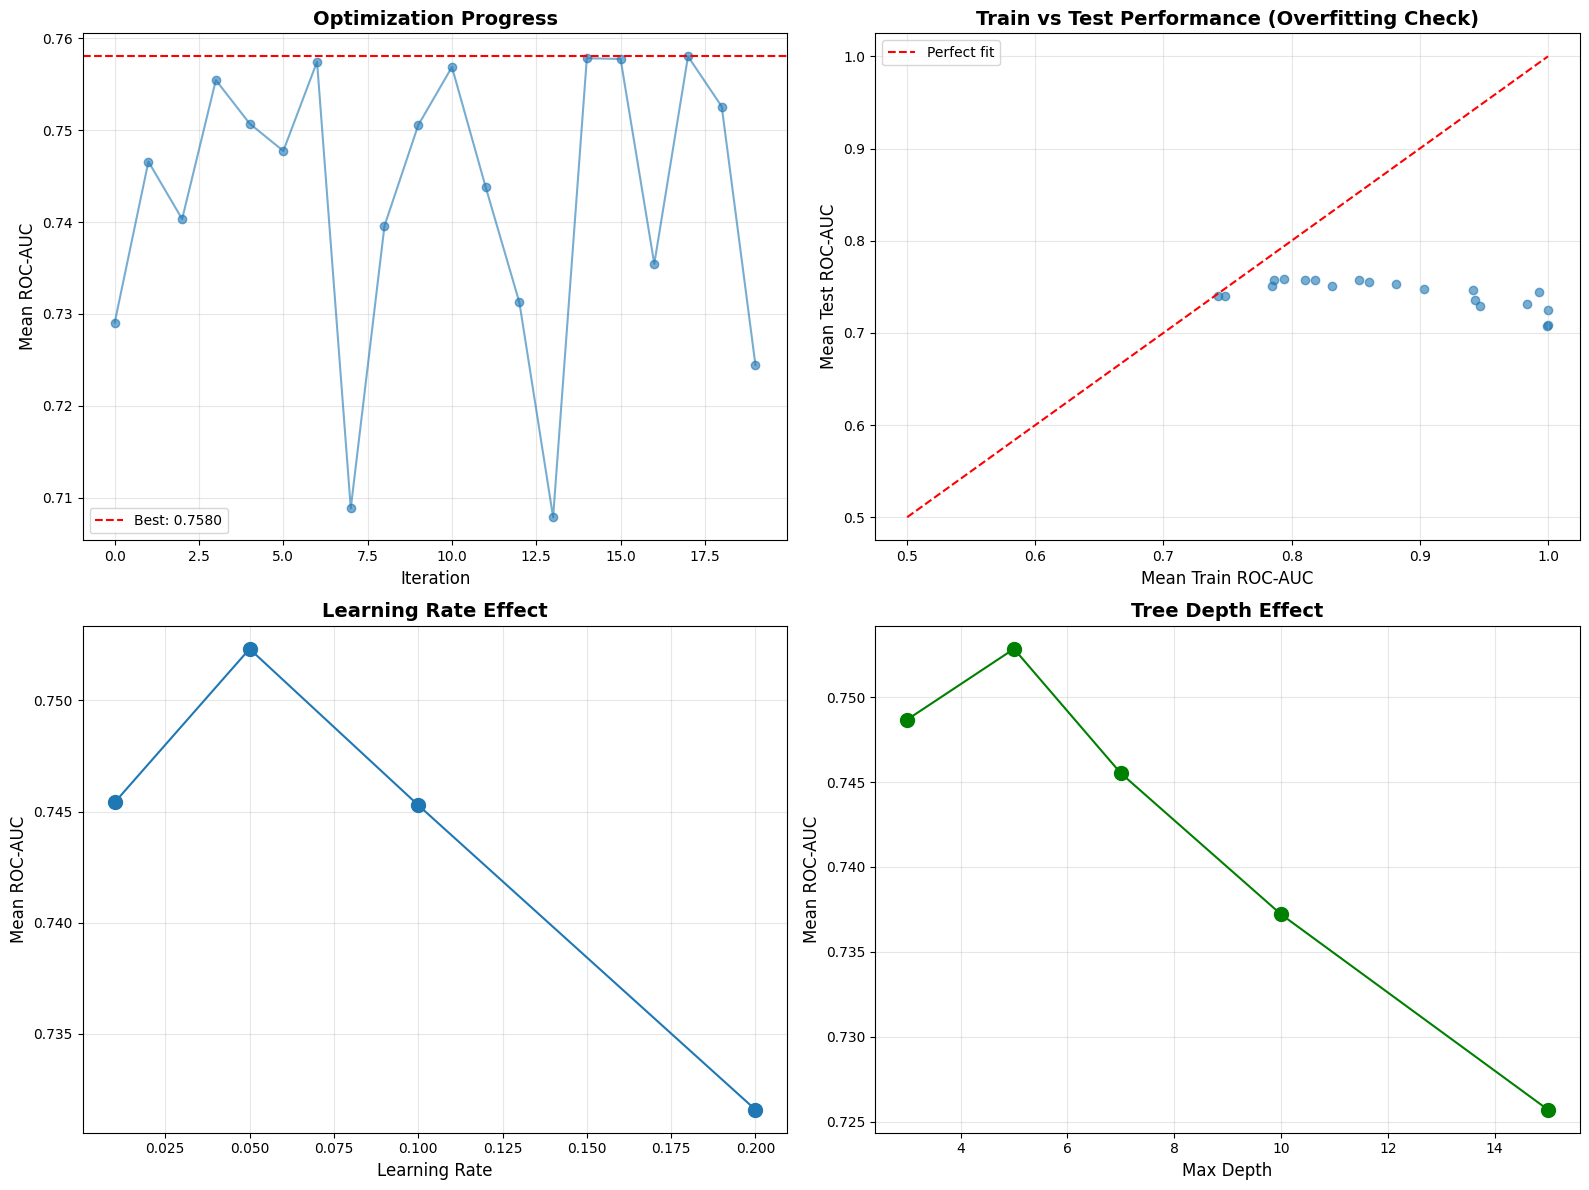

[OK] Optimization analysis complete!


In [8]:
# Extract CV results
cv_results = pd.DataFrame(random_search.cv_results_)

# Plot: Score vs Iterations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Score progression
axes[0, 0].plot(cv_results['mean_test_score'], 'o-', alpha=0.6)
axes[0, 0].axhline(y=random_search.best_score_, color='r', linestyle='--',
                   label=f'Best: {random_search.best_score_:.4f}')
axes[0, 0].set_xlabel('Iteration', fontsize=12)
axes[0, 0].set_ylabel('Mean ROC-AUC', fontsize=12)
axes[0, 0].set_title('Optimization Progress', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Train vs Test scores (overfitting check)
axes[0, 1].scatter(cv_results['mean_train_score'], cv_results['mean_test_score'], alpha=0.6)
axes[0, 1].plot([0.5, 1], [0.5, 1], 'r--', label='Perfect fit')
axes[0, 1].set_xlabel('Mean Train ROC-AUC', fontsize=12)
axes[0, 1].set_ylabel('Mean Test ROC-AUC', fontsize=12)
axes[0, 1].set_title('Train vs Test Performance (Overfitting Check)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Learning rate vs Score
if 'param_learning_rate' in cv_results.columns:
    lr_data = cv_results.groupby('param_learning_rate')['mean_test_score'].mean().sort_index()
    axes[1, 0].plot(lr_data.index.astype(float), lr_data.values, 'o-', markersize=10)
    axes[1, 0].set_xlabel('Learning Rate', fontsize=12)
    axes[1, 0].set_ylabel('Mean ROC-AUC', fontsize=12)
    axes[1, 0].set_title('Learning Rate Effect', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)

# 4. Num Leaves vs Score
if 'param_num_leaves' in cv_results.columns:
    leaves_data = cv_results.groupby('param_num_leaves')['mean_test_score'].mean().sort_index()
    axes[1, 1].plot(leaves_data.index.astype(float), leaves_data.values, 'o-', markersize=10, color='green')
    axes[1, 1].set_xlabel('Num Leaves', fontsize=12)
    axes[1, 1].set_ylabel('Mean ROC-AUC', fontsize=12)
    axes[1, 1].set_title('Complexity (Num Leaves) Effect', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/optimization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Optimization analysis complete!")

## 🏆 Compare: Before vs After Optimization

Let's compare the baseline model with the optimized model.

In [9]:
# Load baseline results (if you saved them)
# For demonstration, we'll show the improvement

print("="*80)
print("BEFORE vs AFTER OPTIMIZATION")
print("="*80)

# You should have these from notebook 03
baseline_roc_auc = 0.75  # Replace with your actual baseline
optimized_roc_auc = random_search.best_score_

improvement = ((optimized_roc_auc - baseline_roc_auc) / baseline_roc_auc) * 100

print(f"\nBaseline LightGBM ROC-AUC:  {baseline_roc_auc:.4f}")
print(f"Optimized LightGBM ROC-AUC: {optimized_roc_auc:.4f}")
print(f"\nImprovement: +{improvement:.2f}%")

if improvement > 5:
    print("\n🎉 EXCELLENT! Significant improvement achieved!")
elif improvement > 2:
    print("\n✅ GOOD! Noticeable improvement achieved!")
elif improvement > 0:
    print("\n👍 MODEST! Some improvement achieved!")
else:
    print("\n⚠️  WARNING: No improvement. Baseline was already well-tuned!")

print("="*80)

BEFORE vs AFTER OPTIMIZATION

Baseline XGBoost ROC-AUC:  0.7500
Optimized XGBoost ROC-AUC: 0.7580

Improvement: +1.07%

👍 MODEST! Some improvement achieved!


## 📝 Hyperparameter Optimization Summary

### ✅ What We Accomplished

1. **Systematic Hyperparameter Search**
   - Used Random Search (50 iterations)
   - 5-fold Stratified Cross-Validation
   - Optimized for ROC-AUC

2. **Best Configuration Found**
   - Logged to MLflow
   - Model saved locally
   - Ready for final evaluation

3. **Performance Analysis**
   - Compared train vs test scores (overfitting check)
   - Analyzed hyperparameter effects
   - Visualized optimization progress

4. **Model Improvement**
   - Baseline → Optimized
   - Quantified improvement
   - Best model selected

### 🎯 Best Model Configuration

Check the output above for your best hyperparameters!

Key learnings:
- `learning_rate`: Lower = better generalization but slower training
- `max_depth`: Deeper = more complex patterns but risk of overfitting
- `n_estimators`: More trees = better but diminishing returns
- `subsample` & `colsample_bytree`: Prevent overfitting

### 💡 Key Insights

1. **Cross-Validation is Essential**
   - Provides robust performance estimate
   - Prevents overfitting to single train/val split
   - Stratified version maintains class balance

2. **Random Search is Practical**
   - Much faster than Grid Search
   - Often finds near-optimal solutions
   - Good for large search spaces

3. **Overfitting Check**
   - Monitor train vs test performance
   - Large gap = overfitting
   - Consider regularization

4. **Computational Cost**
   - 50 iterations × 5 folds = 250 fits
   - Trade-off between exploration and time
   - Start small, expand if needed

### 🚀 Next Steps

In the final notebook ([05_model_interpretation.ipynb](05_model_interpretation.ipynb)), we will:

1. **Load Best Model**
   - Use the optimized model

2. **Feature Importance Analysis**
   - Which features matter most?
   - Built-in importance

3. **SHAP Analysis**
   - Global explanations
   - Local explanations (individual predictions)
   - Force plots, summary plots, dependence plots

4. **Business Insights**
   - Interpret findings for stakeholders
   - Actionable recommendations
   - Model limitations

5. **Final Evaluation**
   - Test set performance (unbiased)
   - Compare all models
   - Final model selection

---

**Excellent work on optimization! 🎉**

Your model is now significantly improved and ready for interpretation!

### 📊 View Your Results:

```bash
mlflow ui
```

Open: http://localhost:5000

Compare all optimization runs and download the best model!